# BEAST Workflow Example

This tutorial provides an example for how to use the Bayesian Extinction and Stellar Tool (BEAST). The tutorial was generated from a Jupyter notebook, which can be downloaded [here](https://github.com/BEAST-Fitting/beast/tree/master/docs/tutorial/tutorial.ipynb). 

Before starting, please make sure you have **at least BEAST v2.0** installed. 

In [7]:
extensions = ["nbsphinx"]
import h5py

import numpy as np
from astropy import wcs
from astropy.io import fits
from astropy.table import Table

import glob
import os
import types
import argparse
import importlib
from IPython.display import Image


import matplotlib.pyplot as plt
%matplotlib inline

from beast.plotting import (plot_mag_hist, 
                            plot_ast_histogram, 
                            plot_noisemodel
)

from beast.tools.run import (
    create_physicsmodel,
    make_ast_inputs,
    create_obsmodel,
    run_fitting,
    merge_files,
    create_filenames,
)

from beast.physicsmodel.grid import SEDGrid
from beast.fitting import trim_grid
import beast.observationmodel.noisemodel.generic_noisemodel as noisemodel
from beast.observationmodel.observations import Observations
    
from beast.tools import (
     beast_settings,
     create_background_density_map,
     split_ast_input_file,
     split_catalog_using_map,
     cut_catalogs,
     setup_batch_beast_trim,
)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# A Brief Introduction to the BEAST

The Bayesian Extinction and Stellar Tool (``BEAST``) is a probabilistic Python program which can be used to model the intrinsic properties of individual stars and dust along each sightline based on their multi-wavelength spectral energy distributions (SEDs). 

To characterize individual stars, the BEAST compares the observed SED of star with predicted/model SEDs. Model SEDs are constructed by generating a grid of stellar spectra across a range of initial masses, ages, and metallicities. Then, varying amounts of extinction are applied to each stellar spectrum based on the dust extinction models (defined by three dust parameters: Av, Rv, and fA which modifies the extinction curve), producing an even larger grid of extinguished spectra. The grid is then duplicated at a range of distances (if relevant), creating a seven-dimensional parameter grid of extinguished stellar spectra. We then integrate these spectra over telescope transmission curves for each observed filter to generate model photometric measurements (i.e. simulated SEDs) for every combination of input stellar and dust parameters. 

Lastly, to account for systemic observational effects in the actual photometry, we use artificial star tests to quantify the average photometric bias as a function of flux in each filter. These biases are added to the predicted SEDs so we can accurately compare with the observed SEDs.


## Step 0. Data Setup


For this example, we will be walking through a standard BEAST workflow example using photometry from the [Panchromatic Hubble Andromeda Treasury (PHAT)](https://archive.stsci.edu/hlsp/phat) survey. 

If you are running this example notebook locally, the example data can be fetched [here](https://www.dropbox.com/sh/91aefrp9gzdc9z0/AAC9Gc4KIRIB520g6a0uLLama?dl=0)

Download the files manually from the link above and place them in a folder called `/data` within the same folder as this notebook.

> **Note:** Sometimes photometric catalogs are delivered as ``HDF5`` files. While these are great for storing data in heirarchies, it's a little hard to work with directly, so we have to convert our ``HDF5`` file to a ``FITS`` file. Thankfully, our photometric catalog for this example is already in a ``FITS`` format so we don't need to worry about this and can move straight on to Step 1.

## Step 1. Reading Photometry

We want to keep all the files we're working with inside a neat directory structure. So here at beginning, let's make set our data directory to be out current working directory.

## Step 1a. Make magnitude histograms

The first thing we need to do is understand the range of stellar magnitudes we are working with in this data set.

To do this, we can make histograms of all the magnitudes of all the stars in all the different filters from the photometric catalog. This is done so that we know where the peaks of the histograms are in each filter. These peaks will then be used later when we make source density maps.

Essentially what happens is that, for the density maps, we only count objects within a certain range, currently set to mag_cut = 15 - (peak_for_filter-0.5). So if the peak was 17.5, then the objects that would be counted would have to be in the range between 15 and 18.

The reason we only count brighter sources is because dimmer sources tend to not be properly observed, especially as the magnitudes near the telescope limit. There will always be far more dim sources than bright sources, but if we know how many bright sources there are, then we can extrapolate as to how many dim sources there should be, and probably get a better understand from that than if we were to try and actually count all the dim sources we detect.

**Variable Information**

- ``field_name`` : the string name of the main photometric catalog we are working with. This variable will be used to rename a lot of different files in the future which is why we have it as a separate variable.
- ``gst_file`` : stands for good-stars, this is the full name for the original photometric catalog we are working with.

In [5]:
field_name = "M31-B09-EAST_chunk"
gst_file = "./data/%s.st.fits" %field_name

We can see what type of data this fits file holds by making a table. There should be around 50,000 sources in this calalog, which is quite small compared to the original file.

Note: ``st`` stands for stars. We also sometimes name things ``gst`` for good stars to signify when cuts have been made.

In [6]:
hdul = fits.open(gst_file)
Table(hdul[1].data)

ModuleNotFoundError: No module named 'numpy.rec'

As we can see, there's a lot of columns describing the photometry. For plotting the magnitude histograms, we're going to be interested in any column that contains the name ``VEGA``. For this example data, there are six filters and these are the columns with the magnitudes for each filter.

We could also use the ``X`` and ``Y`` columns to plot where are the sources are located, or the ``RA`` and ``DEC`` to map their actual position in the sky.

In larger projects we might have multiple fields to analyze during each run, so there would be multiple ``field_names``. Since this is just a small example, we just have one field so our index will always be equal to ``0``.

In [ ]:
# the list of fields (we only have 1 for this example.)
field_names = [field_name]

Now we can create some histogram plots to visualize the magnitude distribution of our sources.



In [ ]:
# this 'if' statement just checks if there's already a histogram file
image_file = './data/'+field_names[0]+'.st_maghist.pdf'
peak_mags = plot_mag_hist.plot_mag_hist(gst_file, stars_per_bin=70, max_bins=75)

You can check out the results for the histograms in the file ending with ``_maghist.pdf``. They should look something like this:

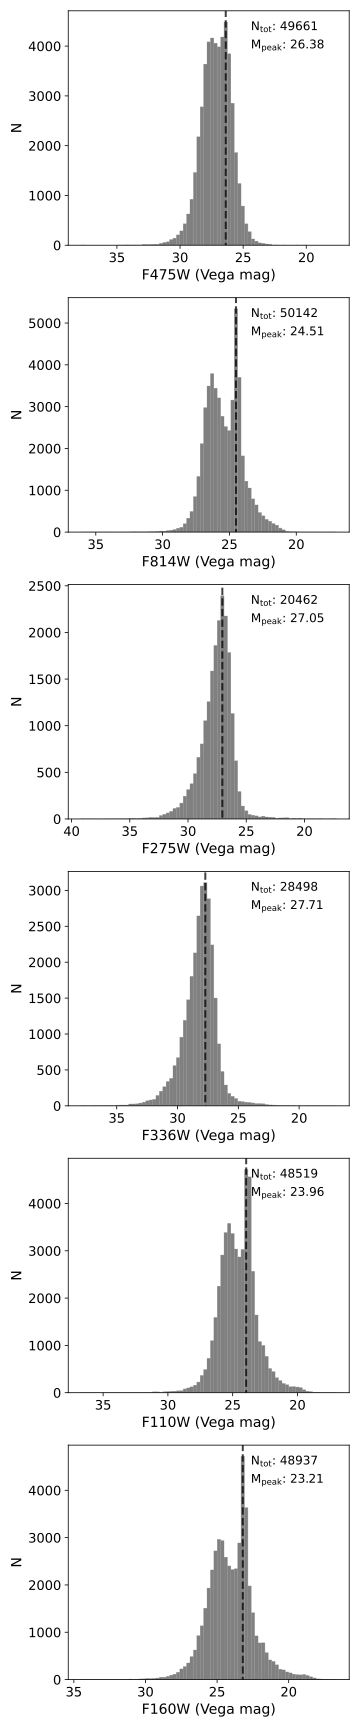

From this plot, we can see that the sources in our field was observed in six different filters, and that the majority of sources are roughly between 20-30 mag in brightness depending on the filter.



## Step 1b. Make source density maps

Next we'll be creating source density maps. These are maps of our data field colored such that they show how many stars/sources there are in each degree field. 

> **Note:** The standard source density pixel 
size is 5 arcsec squared. 

Since we are working with a smaller subset of data, we run the risk of not having enough stars in each source density bin later on when we calculate the noisemodel. To avoid this, we have set our pixel size for this example to 15 arsec, which gives us fewer source density bins but more stars in each source density bin. The size can easily be changed by modifying the `pixsize` variable below.

In [ ]:
# Pick the filter with the dimmest peak from the histogram
ref_filter =["F475W"]

# choose a filter to use for removing artifacts
# (remove catalog sources with filter_FLAG > 99)
flag_filter = ["F475W"]

In [ ]:
# pixel size of 5 arcsec
# use ref_filter[b] between vega mags of 15 and peak_mags[ref_filter[b]]-0.5
# since we're only working with one field, our index b is set to 0
sourceden_args = types.SimpleNamespace(
    subcommand="sourceden",
    catfile=gst_file,
    pixsize=5,
    npix=None,
    mag_name=ref_filter[0]+ "_VEGA",
    mag_cut=[17, peak_mags[ref_filter[0]] - 0.5],
    flag_name=flag_filter[0]+'_FLAG',
    diffSpike=None,
    erode_boundary=None
)

create_background_density_map.main_make_map(sourceden_args)

In [ ]:
# new file name with the source density column
gst_file_sd = gst_file.replace(".fits", "_with_sourceden.fits")

This function should create 3 files:

1. ``M31-B09-EAST_subset.st_source_den_image.fits``: a file for with the source density information which can be viewed in ``ds9`` or with ``matplotlib``

2. ``M31-B09-EAST_subset.st_sourceden_map.hd5``: the same file as ``source_den_image`` but now with the source density information for each source included (the ``split_catalog_using_map`` function used later will assume this name format)

3. ``M31-B09-EAST_subset.st_with_sourceden.fits``: the same as the original photometric file (``gst_file``) but now with an additional column for what density bin the source is located in

### View the fits images of the source density maps
Now that we have the source density maps outputted, we can plot the image and see that the density looks like.

In [ ]:
stats = Table.read(gst_file)

fig, ax = plt.subplots(1,1, figsize=(6, 4.5))

cbar = ax.scatter(stats["RA"], stats["DEC"], s=0.1, c=stats["F475W_VEGA"], vmin=25, vmax=30)
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
plt.colorbar(cbar, label="F475W (mag)")
plt.show()

In [ ]:
# open the fits file
hdu_list = fits.open("./data/%s.st_source_den_image.fits"%field_name)
hdu_list.info()

# extract the image data
image_data = hdu_list[0].data

# close the fits file
hdu_list.close()

# plot the extracted image data
fig = plt.figure(0, [6, 5])
im = plt.imshow(image_data, origin="lower")
plt.colorbar(im)
plt.xlabel("Pixel (originally RA)")
plt.ylabel("Pixel (originally DEC)")
plt.title("Density of Sources per 5 arcsec^2")
plt.show()

## Step 1c. Set up beast_settings.txt file

At this point, we have a basic understanding of the information we are working with, so it's about time we set up our ``beast_settings.txt`` file. 

The ``beast_settings`` file is a sort of catch-all file used to store any sort of infomation we might need to run the BEAST code on our data. We'll go through and talk about what all the different variables mean, and which ones would need to be changed for any future projects.

Variables labeled AC (either here or in ``beast_settings.txt``) are where the user's input change is NOT necessary/recommended

For convenience, we state the path here, as we'll be updating and reloading this file a few times throughout.

In [ ]:
settings_path = "./data/beast_settings.txt"

Go ahead and open the beast_settings.txt file in a text editor now and ensure that the following variables match:

*  **project** : the same as the field_name variable we noted earlier
    * `project = "M31-B09-EAST_chunk" `
    
    
* **surveyname** : the overall name for the survey (this variable isn't actually important for the code)
    * `surveyname = "PHAT-M31"`
    
    
* **filters** : the full filter names from the photometric catalog, also the names that show up in our magnitude histograms so you can add them from there
    * `filters = ["HST_WFC3_F275W", "HST_WFC3_F336W","HST_WFC3_F475W", "HST_WFC3_F814W", "HST_WFC3_F110W", "HST_WFC3_F160W",]`
    
    
* **base filters** : shortened versions of the filter names
    * `basefilters = ["F275W", "F336W", "F475W", "F814W", "F110W", "F160W"]`
    
    
* **obsfile** : the name of the photometric catalog
    * *`obsfile = "./data/" + project + ".gst.fits"`
    
    
* **noisefile** : absflux calibration covariance matrix for HST specific filters (AC)
    * `noisefile = "./data/" + project + "_noisemodel.hd5"`
    
    
* **absflux_a_matrix** : absflux calibration covariance matrix for HST specific filters (AC)
    * `absflux_a_matrix = absflux_covmat.hst_frac_matrix(filters)`
    
    
    

There will be the following parameters common to all methods of AST generation:


* **ast_with_positions** : make sure is set to *True* if you have the locations included in your obsfile
    * `ast_with_positions = True`
    
    
* **ast_realization_per_model** : number of realizations of each included AST model to be put into the list; the default (20) is necessary for truncheon noise model, but one realization is sufficient for the toothpick noise model.
    * `ast_realization_per_model = 1`


* **ast_density_table** : the source density map created in step 1b  
    * `ast_density_table = '"./M31-B09-EAST_chunk.st_sourceden_map.hd5"`
    
    
* **ast_pixel_distribution** : (used if ast_with_positions is True), minimum pixel separation between AST position and catalog star used to determine the AST spatial distribution  
    * `ast_pixel_distribution = 10.0`
    
    
* **ast_reference_image** : the original photometric FITS catalog which is required if you use the ast_with_positions as true  
    * `ast_reference_image = "M31-B09-BEAST_chunk_F475W_drz.chip1.fits"`
    
    
* **astfile** : the file of ASTs we will be creating in step 3, but since ASTs normally have to be processed by a specialist, we have already included a finished AST file for us to use in this example
    * `astfile = "./M31-B09-EAST_chunk.gst.fake.fits"`
    
    
* **ast_colnames** : names of columns for filters in the AST catalog (AC)
    * `ast_colnames = np.array(basefilters)`
    
    
* **n_subgrid** : the number of subgrids to use for generating the physics model later on (with 1 meaning no subgrids); this notebook workflow **requires** n_subgrid >= 2
    * `n_subgrid = 2`
    
    
    

 

For the recommended manner of AST generation, which is by source density binning, there are also the following options to set:

* **sd_binmode** : whether to use linear or logarithmic source density binning
    * *sd_binmode = "log"*
    
    
* **sd_Nbins** : number of bins in source density to use
    * *sd_Nbins = "10"*
    
    
* **sd_binwidth** : width of soruce density bins; only used for linear spacing
    * *sd_binwidth = None*
    
    
* **sd_custom** : width of soruce density bins; only used for linear spacing
    * *sd_custom = None*
    
    
* **ast_n_flux_bins** : number of flux bins into which the dynamic range of the model grid in each filter is divided (if pick_models_toothpick_style is used)
    * *ast_n_flux_bins = 100*  
    
    
* **ast_n_per_flux_bin** : minimum number of model SEDs that need to fall into each bin (if pick_models_toothpick_style is used)
    * *ast_n_per_flux_bin = 50*  
    
    
* **ast_bands_above_maglimit** : number of filters that must be above the magnitude limit for an AST to be included in the list
    * *ast_bands_above_maglimit = 3*  
    
    
* **ast_models_selected_per_age** : number of models to pick per age
    * *ast_models_selected_per_age = 100*  
    
    
    
    

This file is also where you specify the parameters and resolution of your physics model which will become relevant in step 2. The resolution of these parameters for your own runs will differ depending on what sorts of ASTs you want to model. There are 8 parameters that can be set.

1. **Distance** : either a fixed value or a range with stepsizes
2. **Velocity** : what is the heliocentric velocity of your location or galaxy in km/s
3. **Age** : the log10 age range of the ASTs being modeled
4. **Mass** : the mass of the ASTs
5. **Metallicity** : the metallicity range of the ASTs

6. **A(v)** : the range of dust extinction in magnitudes that could be dimming the intrinsic brightness of the ASTs
7. **R(v)** : the range of dust grain sizes 
8. **f(A)** the mixture factor between the Milky Way and Small Magellanic Cloud extinction curves

Our goal after this would normally be to eventually run a bunch of **ASTs** (Artificial Star Tests), but before we can do that, we need to generate the fake stars to use.

Since the ASTs would normally need to be analyzed by a specialist after being created and that's a little overkill for a small example, these next couple of steps are just to illustrate how the ASTs are actually generated. A finished file of the analyzed ASTs already exists so we will end up using that in step 4 and beyond.



# Step 2. Create Stellar SED Model Grid (Physics Model)

In order to generate a diverse and representative sample of fake stars to use for our ASTs, we need to set up a N-dimensional model of possible stellar parameters, so that we can easily and randomly select stars from the model.

This model is called a **physics model**, and we will be using the parameters set in the beast_settings.txt file to create this N-dimensional grid.

> **Note:** the resolution on the stellar parameters (the step size, often specified as the third input e.g. logt = [6.0, 10.13, 1.0], where 1.0 is the step size) is the main factor driving how long this physics grid will take to set up. If things take a very long time to run, consider making the step size larger for testing's sake.

Sometimes we are able to have access to high-performance computing resources, meaning we can split the physics model into subgrids and run them in parallel, cutting a lot of the computation time. While we're like not running this notebook in parallel here, we've still specified a number of subgrids in the ``beast_settings.txt`` file. 

We can check how many subgrids are set up.

In [ ]:
settings = beast_settings.beast_settings(settings_path)
print(settings.n_subgrid)

So we can now see that we've asked for 2 grids in the ``beast_settings.txt`` file.

If we've already generated a physics model, we certainly don't want to run it again, so the following code checks to make sure all the subgrids for the physics model are present.

In [ ]:
# set up the naming conventions for the physics model
gs_str = ""

# this is only relevant if we run with multiple subgrids
if settings.n_subgrid > 1:
    gs_str = "sub*"

# collects any physics models that have already been created
# if none have, sed_files will be empty
sed_files = glob.glob("./data/{0}_seds.grid{1}.hd5".format(field_names[0], gs_str))
print(sed_files)

In [ ]:
# only make the physics model if it doesn't already exist
if len(sed_files) < settings.n_subgrid:
    
    # directly create physics model grids
    create_physicsmodel.create_physicsmodel(beast_settings_info=settings_path, nprocs=1, nsubs=settings.n_subgrid)